# 효율적인 트랜스포머 구축
- 애플리케이션에 대한 비즈니스 요구사항을 만족시키기에 모델이 너무 느리거나 크다면 최고 성능의 모델이라도 유용하지 않다.
- 당연히 그 대안은 빠르고 작은 모델을 훈련하는 것이다.
- 하지만 모델 용량을 줄이면 종종 성능이 저하된다. 
- 그럼 빠르고 작지만 정확도가 높은 모델이 필요할 땐 어떻게 해야할까?
- 예측 속도를 높이고, 트랜스포머 모델의 메모리 사용량을 줄이는 네 가지 기술
    - 지식 전제(knowledge distillation)
    - 양자화(quantization)
    - 가지치기(pruning)
    - ONNX(open Neural Network Exchange) 포맷과 ONNX 런타임(ORT)을 사용한 그래프 최적화(graph optimization)
- 추가로 이런 기술을 연결해 성능을 크게 향상하는 방법도 알아보겠다.
- 로블록스 엔지니얼이 팀은 블로그 포스트에서 이런 방법을 소개했다.
- 이 팀은 지식 정제와 양자화를 연결해 레이턴시와 BERT 분류기의 처리 성능을 30배 이상 향상했다.

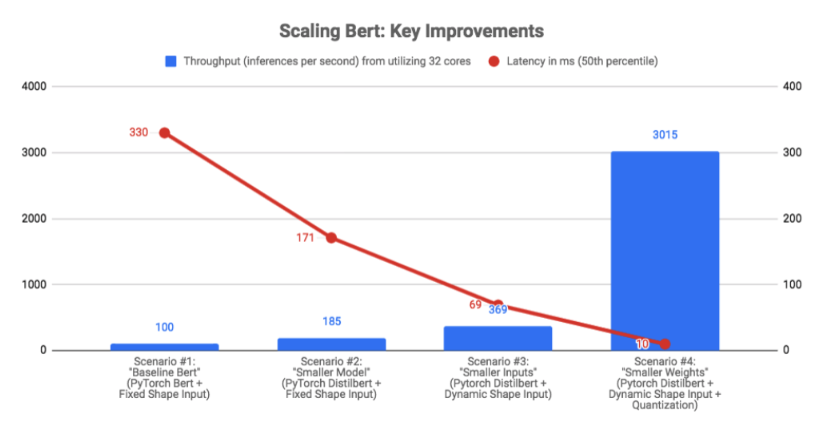

- 각 기술의 장단점을 이해하기 위해 의도 탐지(intent detection) 예제를 들겠다.
- 의도 탐지는 텍스트 기반 어시스턴트(assistant) 시스템에서 중요한 구성 요소
- 여기서 실시간 대화를 유지하려면 레이턴시가 낮아야 한다.
- 이를 통해 사용자 정의 트레이너를 만드는 방법, 효율적으로 하이퍼파라미터 검색을 수행하는 방법을 배우겠다.
- 또 트랜스포머로 최신 연구를 구현하는 데 필요한 사항을 알아보겠다.

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=8)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 538, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 538 (delta 165), reused 184 (delta 107), pack-reused 266
Receiving objects: 100% (538/538), 46.22 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (264/264), done.
/kaggle/working/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.20.1
Using datasets v2.1.0
Using accelerate v0.12.0
Using optuna v3.0.5
Using onnxruntime v1.13.1
Using onnx v1.13.0


## 1. 의도 탐지 예제
- 고객의 목적을 이해하기 위해 다양한 자연어 텍스트를 사전에 정의된 일련의 행동이나 의도로 분류해야한다.
- 고객이 사전에 정의된 의도에 속하지 않은 쿼리를 제공하면 시스템은 대체 응답을 출력해야한다.

In [3]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

Downloading:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

2023-01-17 04:26:36.130324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:26:36.131332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:26:36.132372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:26:36.133137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 04:26:36.133902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [4]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in 
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490036010742188}]

## 2. 벤치마크 클래스 만들기
- 제품 환경에 배포하려면 여러가지 제약 조건을 절출해야한다.
    - 모델 성능
         - 제품 환경의 데이터를 반영하는 잘 준비된 테스트 세트에서 모델은 얼마나 잘 작동할까
         - 모델 성능은 특히 오류가 발생했을 때 손실 비용이 큰 상황이나(또는 오류 발생을 줄이기 위헤ㅐ 사람이 참여하는 것이 최선일 때)
         - 수백만 개의 샘플에서 추론을 실행해야 하므로 모델 지표가 조금 향상되면 젙체적으로 큰 이득을 얻을 수 있는 상황에서 중요합니다.
    - 레이턴시
        - 모델이 얼마나 빠르게 예측을 만드나요?
        - 레이턴시는 보통 대량의 트래픽을 처리하는 실시간 환경에서 고려한다.
        - 예를 들면, 스택 오버플로는 웹사이트에서 부적절한 댓글을 빠르게 감지하는 분류기가 필요하다.
    - 메모리
        - GPT-2나 T5처럼 파라미터가 십업 개가 돼서 기가바이트 단위의 디스크와 램이 필요한 모델은 어떻게 배포할까?
        - 메모리는 모바일과 에지 장치에서 특별히 중요한 역할을 수행한다.
        - 이 환경에서는 모델이 강력한 클라우드 서버에 접속하지 않고 예측을 만들어야 한다.
 
 
> 다양한 압축 기법으로 최적화 하는 방법을 알아보기 위해 먼저 파이프라인과 테스트 세트가 주어지면 성능을 측정하는 간단한 벤치마크 클래스를 만들겠다.

In [5]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type='BERT baseline'):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type
        
    def compute_accuracy(self):
        pass
    
    def compute_size(self):
        pass
    
    def time_pipeline(self):
        pass
    
    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

- 이 장에서 다룰 여러 가지 최적화 기법의 성능을 추적하기 위해 optim_type 매개변수를 정의했다.
- run_benchmark() 메서드를 사용해 딕셔너리에 optim_type을 키로 모든 지표를 저장한다.

In [6]:
from datasets import load_dataset

clinc = load_dataset('clinc_oos', 'plus') # plus 설정은 범위 밖의 훈련 샘플이 담긴 세브셋을 의미한다.


Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

- 여기에서 plus 설정은 범위 밖의 훈련 샘플이 담긴 서브셋을 의미한다.
- CLINC150의 각 샘플은 text 열에 있는 쿼리와 이에 상응하는 의도로 구성됐다.

In [7]:
sample = clinc['test'][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [8]:
intents = clinc['test'].features['intent']
intents.int2str(sample['intent'])

'transfer'

In [9]:
from datasets import load_metric

accuracy_score = load_metric('accuracy')

- 정확도 지표는 정수로 표현된 예측과 참조(즉, 정답 레이블)를 기대합니다.
- 이를 위해 파이프라인을 사용해 text 필드에서 예측을 추출하고, 
- intents 객체의 str2int() 메서드를 사용해 각 예측을 해당 ID로 매핑한다.
- 다음 코드는 데이터셋의 모든 예측과 레이블을 리스트로 취합한 후 정확도를 계산해 반환한다.
- 이 메서드를 PerformanceBenchmark 클래스에 추가하겠다.

In [10]:
def compute_accuracy(self):
    """PerformanceBenchmark.compute_accuracy() 메서드를 오버라이드합니다"""
    preds, labels = [], []
    for example in self.dataset:
        pred = self.pipeline(example["text"])[0]["label"]
        label = example["intent"]
        preds.append(intents.str2int(pred))
        labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"테스트 세트 정확도 - {accuracy['accuracy']:.3f}")
    return accuracy

PerformanceBenchmark.compute_accuracy = compute_accuracy

In [11]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

- 그 다음 파이토치의 torch.save() 함수를 사용해 모델을 디스크에 직렬화하고 크기를 계산해보자
- 내부적으로 torch.save()는 파이썬의 pickle 모듈을 사용하며, 모델을 비룻해 텐서, 일반적인 파이썬 객체까지 그 어떤 것도 저장할 수 있다.
- 파이토치에서는 모델을 저장할 때 state_dict() 메서드를 사용하길 추천합니다.
- 이 메서드는 모델의 층과 학습 가능한 파라미터(즉, 가중치와 편향)를 매핑하는 파이썬 딕셔너리를 반환합니다.
- 기준 모델의 state_dict() 메서드가 반환한 내용을 확인해보자

In [12]:
list(pipe.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

- 각각의 키/값 쌍이 BERT의 층과 텐서에 해당된다.
- 따라서 모델은 다음고과 같은 방식으로 저장한다.

In [13]:
torch.save(pipe.model.state_dict(), 'model.pt')

- 그 다음 파이썬의 pathlib 모듈의 Path.stat() 함수를 사용해 저장된 파일의 정볼르 얻습니다.
- 특히 Path("model.pt").stat().st_size에는 모델 크기가 바이트 단위로 저장됐습니다.
- 이런 정보를 모두 사용해 compute_size() 함수를 만들고 PerformanceBenchmark 클래스에 추가하겠습니다.

In [14]:
import torch
from pathlib import Path

def compute_size(self):
    """PerformanceBenchmark.compute_size() 메서드를 오버라이드합니다"""
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # 메가바이트 단위로 크기를 계산합니다
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # 임시 파일을 삭제합니다
    tmp_path.unlink()
    print(f"모델 크기 (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}

PerformanceBenchmark.compute_size = compute_size

- 마지막으로 쿼리마다 평균적인 레이턴시를 재기 위해 time_pipeline() 함수를 구현하겠다.
- 이 애플리케이션에서 레이턴시는 파이프라인에 텍스트 쿼리를 주입하고 모델로부터 예측된 의도가 반환되기 까지 걸린 시간을 의미한다.
- 파이프라인은 내부적으로 텍스트를 토큰화하지만 이 작업은 예측을 생성하는 것보다 천 배 가량 더 빠르다.
- 따라서 전체적인 레이턴시에 미치는 영향을 무시해도 무방하다.
- 코드 실행 시간을 측정하는 간단한 방법은 파이썬의 time 모델이 제공하는 perf_counter() 함수를 사용하는 것이다.
- 이 함수를 time.time()함수보다 더 미세한 수준으로 시간을 측정해 정밀한 결과를 요하는 곳에 적합하다.

> 파이프라인에 테스트 쿼리를 전달하고 perf_counter()를 사용해 코드 실행의 시작과 끝 시간 차이를 밀리초 단위로 계산하겠습니다.

In [15]:
from time import perf_counter

for _ in range(3):
    start_time = perf_counter()
    _ = pipe(query)
    latency = perf_counter() - start_time
    print(f"레이턴시 (ms) - {1000 * latency:.3f}")

레이턴시 (ms) - 122.268
레이턴시 (ms) - 115.704
레이턴시 (ms) - 116.344


- 결과를 보면 레이턴시 차이가 크다.
- 파이프라인의 1회 실생 시간을 재보면 코드를 실행할 때마다 결과가 달라진다.
- 그러므로 파이프라인을 여러 번 실행해 레이턴시를 수집하고 그 결과의 평균과 표준편차를 계산한 후, 분포를 구해 값이 얼마나 퍼져 있는지 파악해야 한다.
- 다음 코드에는 실제 실행을 수행하기 전에 CPU를 워밍업 하는 단계가 포함됐다.

In [16]:
import numpy as np

def time_pipeline(self, query="What is the pin number for my account?"):
    """PerformanceBenchmark.time_pipeline() 메서드를 오버라이드합니다d"""
    latencies = []
    # 워밍업
    for _ in range(10):
        _ = self.pipeline(query)
    # 실행 측정
    for _ in range(100):
        start_time = perf_counter()
        _ = self.pipeline(query)
        latency = perf_counter() - start_time
        latencies.append(latency)
    # 통게 계산
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"평균 레이턴시 (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

PerformanceBenchmark.time_pipeline = time_pipeline

In [17]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

모델 크기 (MB) - 418.16
평균 레이턴시 (ms) - 118.63 +\- 8.75
테스트 세트 정확도 - 0.867


## 3. 지식 정제로 모델 크기 줄이기
- 작은 스튜던트 모델을 훈련하는 방법으로, 느리고 크지만 성능이 더 높은 티처의 동작을 모방하도록 작은 스튜던트 모델을 훈련한다.
- 지식정제는 앙상블 모델을 위해 2006년에 처음 소개 됐다
- 2015년에 발표된 유명한 논문에서 심층 신경망에 이 방법을 일반화해 이미지 분류와 자동 음성 인식에 적용하면서 널리 알려졌다.
- 사전 훈련하는 언어 모델의 파라미터 개수가 꾸준히 증가하는 경향을 고려할때
- 지식 정제는 대규모 모델을 압축해 실용적인 애플리케이션 구축에 적합하게 만드는 인기있는 전략이다.

### 1) 미세 튜닝에서의 지식 정제
- 훈련하는 동안 지식은 어떻게 정제되고 티쳐에서 스튜던트로 전달될까?
- 미세튜닝 같은 지도 학습 작업에서는 티처의 소프트 확률로 정답 레이블을 보강해서 스튜던트가 학습할 때 부가 정보를 제공하는 것이 주요 아이디어이다
- 예를 들어 bert 기반 분류기가 여러 개의 의도에 높은 확률을 할당한다면, 이 의도는 특성 공간 안에서 서로 가까이 위치한다는 신호일 가능성이 있다.
- 이런 확률을 모방하도록 스튜던트 훈련해서 티처가 학습한 검은 지식을 정제한다.
- 검은 지식이란 레이블만으로는 얻지 못하는 지식이다.


- 수학적으로는 입력 시퀀스 X를 티처에 전달해 로짓 벡터를 생성한다. 이 로짓에 소프트맥스 함수를 적용하면 확률로 변환된다.
- 하지만 많은 경우, 티처가 한 클래스에 높은 확률을 할당해서 나머지 클래스 확률이 0에 가까워지며 이는 우리가 원하는 바가 아니다.
- 이 경우 티처는 정답 레이블 외에 추가 정보를 많이 제공하지 않으면